# Deep Convolutional GAN (DCGAN)

### Goal
In this notebook, you're going to create another GAN using the MNIST dataset. You will implement a Deep Convolutional GAN (DCGAN), a very successful and influential GAN model developed in 2015.

*Note: [here](https://arxiv.org/pdf/1511.06434v1.pdf) is the paper if you are interested! It might look dense now, but soon you'll be able to understand many parts of it :)*

### Learning Objectives
1.   Get hands-on experience making a widely used GAN: Deep Convolutional GAN (DCGAN).
2.   Train a powerful generative model.


![Generator architecture](dcgan-gen.png)

Figure: Architectural drawing of a generator from DCGAN from [Radford et al (2016)](https://arxiv.org/pdf/1511.06434v1.pdf).

## Getting Started

#### DCGAN
Here are the main features of DCGAN (don't worry about memorizing these, you will be guided through the implementation!):

<!-- ```
Architecture guidelines for stable Deep Convolutional GANs
• Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).
• Use BatchNorm in both the generator and the discriminator.
• Remove fully connected hidden layers for deeper architectures.
• Use ReLU activation in generator for all layers except for the output, which uses Tanh.
• Use LeakyReLU activation in the discriminator for all layers.
``` -->


*   Use convolutions without any pooling layers
*   Use batchnorm in both the generator and the discriminator
*   Don't use fully connected hidden layers
*   Use ReLU activation in the generator for all layers except for the output, which uses a Tanh activation.
*   Use LeakyReLU activation in the discriminator for all layers except for the output, which does not use an activation

You will begin by importing some useful packages and data that will help you create your GAN. You are also provided a visualizer function to help see the images your GAN will create.

In [24]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import json


torch.manual_seed(0) # Set for testing purposes, please do not change!
np.random.seed(42)


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## Generator
The first component you will make is the generator. You may notice that instead of passing in the image dimension, you will pass the number of image channels to the generator. This is because with DCGAN, you use convolutions which don’t depend on the number of pixels on an image. However, the number of channels is important to determine the size of the filters.

You will build a generator using 4 layers (3 hidden layers + 1 output layer). As before, you will need to write a function to create a single block for the generator's neural network.
<!-- From the paper, we know to "[u]se batchnorm in both the generator and the discriminator" and "[u]se ReLU activation in generator for all layers except for the output, which uses Tanh." -->
Since in DCGAN the activation function will be different for the output layer, you will need to check what layer is being created. You are supplied with some tests following the code cell so you can see if you're on the right track!

At the end of the generator class, you are given a forward pass function that takes in a noise vector and generates an image of the output dimension using your neural network. You are also given a function to create a noise vector. These functions are the same as the ones from the last assignment.

<details>
<summary>
<font size="3" color="green">
<b>Optional hint for <code><font size="4">make_gen_block</font></code></b>
</font>
</summary>

1. You'll find [nn.ConvTranspose2d](https://pytorch.org/docs/master/generated/torch.nn.ConvTranspose2d.html) and [nn.BatchNorm2d](https://pytorch.org/docs/master/generated/torch.nn.BatchNorm2d.html) useful!
</details>

In [83]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Generator
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN,
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''

        #     Steps:
        #       1) Do a transposed convolution using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a ReLU activation.
        #       4) If its the final layer, use a Tanh activation after the deconvolution.

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
                #### END CODE HERE ####
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

In [3]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
'''
Test your make_gen_block() function
'''
gen = Generator()
num_test = 100

# Test the hidden block
test_hidden_noise = get_noise(num_test, gen.z_dim)
test_hidden_block = gen.make_gen_block(10, 20, kernel_size=4, stride=1)
test_uns_noise = gen.unsqueeze_noise(test_hidden_noise)
hidden_output = test_hidden_block(test_uns_noise)

# Check that it works with other strides
test_hidden_block_stride = gen.make_gen_block(20, 20, kernel_size=4, stride=2)

test_final_noise = get_noise(num_test, gen.z_dim) * 20
test_final_block = gen.make_gen_block(10, 20, final_layer=True)
test_final_uns_noise = gen.unsqueeze_noise(test_final_noise)
final_output = test_final_block(test_final_uns_noise)

# Test the whole thing:
test_gen_noise = get_noise(num_test, gen.z_dim)
test_uns_gen_noise = gen.unsqueeze_noise(test_gen_noise)
gen_output = gen(test_uns_gen_noise)

Here's the test for your generator block:

In [4]:
# UNIT TESTS
assert tuple(hidden_output.shape) == (num_test, 20, 4, 4)
assert hidden_output.max() > 1
assert hidden_output.min() == 0
assert hidden_output.std() > 0.2
assert hidden_output.std() < 1
assert hidden_output.std() > 0.5

assert tuple(test_hidden_block_stride(hidden_output).shape) == (num_test, 20, 10, 10)

assert final_output.max().item() == 1
assert final_output.min().item() == -1

assert tuple(gen_output.shape) == (num_test, 1, 28, 28)
assert gen_output.std() > 0.5
assert gen_output.std() < 0.8
print("Success!")

Success!


## Discriminator
The second component you need to create is the discriminator.

You will use 3 layers in your discriminator's neural network. Like with the generator, you will need create the function to create a single neural network block for the discriminator.
<!-- From the paper, we know that we need to "[u]se LeakyReLU activation in the discriminator for all layers." And for the LeakyReLUs, "the slope of the leak was set to 0.2" in DCGAN. -->
There are also tests at the end for you to use.
<details>
<summary>
<font size="3" color="green">
<b>Optional hint for <code><font size="4">make_disc_block</font></code></b>
</font>
</summary>

1. You'll find [nn.Conv2d](https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html), [nn.BatchNorm2d](https://pytorch.org/docs/master/generated/torch.nn.BatchNorm2d.html), and [nn.LeakyReLU](https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html) useful!
</details>

In [5]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Discriminator
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN,
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        #     Steps:
        #       1) Add a convolutional layer using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a LeakyReLU activation with slope 0.2.

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
                #### END CODE HERE ####
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor,
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [6]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
'''
Test your make_disc_block() function
'''
num_test = 100

gen = Generator()
disc = Discriminator()
test_images = gen(get_noise(num_test, gen.z_dim))

# Test the hidden block
test_hidden_block = disc.make_disc_block(1, 5, kernel_size=6, stride=3)
hidden_output = test_hidden_block(test_images)

# Test the final block
test_final_block = disc.make_disc_block(1, 10, kernel_size=2, stride=5, final_layer=True)
final_output = test_final_block(test_images)

# Test the whole thing:
disc_output = disc(test_images)

Here's a test for your discriminator block:

In [7]:
# Test the hidden block
assert tuple(hidden_output.shape) == (num_test, 5, 8, 8)
# Because of the LeakyReLU slope
assert -hidden_output.min() / hidden_output.max() > 0.15
assert -hidden_output.min() / hidden_output.max() < 0.25
assert hidden_output.std() > 0.5
assert hidden_output.std() < 1

# Test the final block

assert tuple(final_output.shape) == (num_test, 10, 6, 6)
assert final_output.max() > 1.0
assert final_output.min() < -1.0
assert final_output.std() > 0.3
assert final_output.std() < 0.6

# Test the whole thing:

assert tuple(disc_output.shape) == (num_test, 1)
assert disc_output.std() > 0.25
assert disc_output.std() < 0.5
print("Success!")

Success!


## Training
Now you can put it all together!
Remember that these are your parameters:
  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   beta_1, beta_2: the momentum term
  *   device: the device type

<!-- In addition, be warned that **this runs very slowly on the default CPU**. One way to run this more quickly is to download the .ipynb and upload it to Google Drive, then open it with Google Colab, click on `Runtime -> Change runtime type` and set hardware accelerator to GPU and replace
`device = "cpu"`
with
`device = "cuda"`. The code should then run without any more changes, over 1,000 times faster.  -->


In [8]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ but you don’t need to worry about it for this course!
beta_1 = 0.5
beta_2 = 0.999
device = 'cpu'
batch_size = 128

# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Then, you can initialize your generator, discriminator, and optimizers.

In [9]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Finally, you can train your GAN!
For each epoch, you will process the entire dataset in batches. For every batch, you will update the discriminator and generator. Then, you can see DCGAN's results!

Here's roughly the progression you should be expecting. On GPU this takes about 30 seconds per thousand steps. On CPU, this can take about 8 hours per thousand steps. You might notice that in the image of Step 5000, the generator is disproprotionately producing things that look like ones. If the discriminator didn't learn to detect this imbalance quickly enough, then the generator could just produce more ones. As a result, it may have ended up tricking the discriminator so well that there would be no more improvement, known as mode collapse:
![MNIST Digits Progression](MNIST_DCGAN_Progression.png)


In [10]:
# gen = Generator(z_dim).to(device)
# gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
# disc = Discriminator().to(device)
# disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# n_epochs = 50
# cur_step = 0
# mean_generator_loss = 0
# mean_discriminator_loss = 0

# # Define the file path to save the generator weights
# generator_weights_path = 'generator_epoch_{epoch}.pth'

# for epoch in range(n_epochs):
#     # Dataloader returns the batches
#     for real, _ in tqdm(dataloader):
#         cur_batch_size = len(real)
#         real = real.to(device)

#         ## Update discriminator ##
#         disc_opt.zero_grad()
#         fake_noise = get_noise(cur_batch_size, z_dim, device=device)
#         fake = gen(fake_noise)
#         disc_fake_pred = disc(fake.detach())
#         disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
#         disc_real_pred = disc(real)
#         disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
#         disc_loss = (disc_fake_loss + disc_real_loss) / 2

#         # Keep track of the average discriminator loss
#         mean_discriminator_loss += disc_loss.item() / display_step
#         # Update gradients
#         disc_loss.backward(retain_graph=True)
#         # Update optimizer
#         disc_opt.step()     

#         ## Update generator ##
#         gen_opt.zero_grad()
#         fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
#         fake_2 = gen(fake_noise_2)
#         disc_fake_pred = disc(fake_2)
#         gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
#         gen_loss.backward()
#         gen_opt.step()

#         # Keep track of the average generator loss
#         mean_generator_loss += gen_loss.item() / display_step

#         ## Visualization code ##
#         if cur_step % display_step == 0 and cur_step > 0:
#             print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
#             show_tensor_images(fake)
#             show_tensor_images(real)
#             mean_generator_loss = 0
#             mean_discriminator_loss = 0
#         cur_step += 1

#     # Save the generator weights
#     torch.save(gen.state_dict(), generator_weights_path.format(epoch=epoch))

  0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

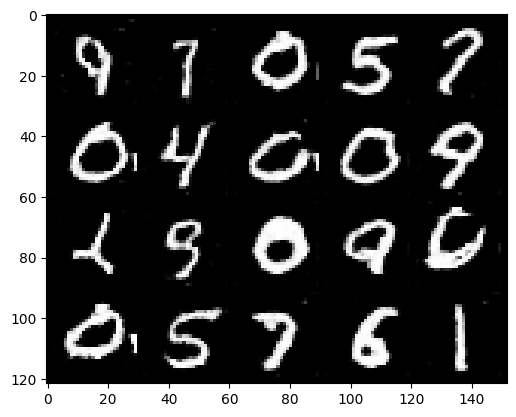

In [11]:
## GENERATE IMAGES USING THE GENERATOR
import torch
import torchvision
import matplotlib.pyplot as plt

# Assuming z_dim is the noise dimension used during training, for example, 64
z_dim = 64

# Instantiate the generator
generator = Generator(z_dim=z_dim)

# If you have saved model weights from training, load them
generator.load_state_dict(torch.load('generator_epoch_saved_weights/generator_epoch_49.pth'))

generator.eval()  # Set the generator to evaluation mode

# Function to create noise vectors
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

# Lock the random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)

# Generate Noise Vectors
num_images = 20  # Number of images you want to generate
noise_vectors = get_noise(num_images, z_dim, device='cpu')

# Generate Images
with torch.no_grad():  # No need to compute gradients for generating images
    generated_images = generator(noise_vectors)

# Visualize Generated Images
def show_tensor_images(image_tensor, num_images=20, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2  # De-normalize images to range [0, 1]
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = torchvision.utils.make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

show_tensor_images(generated_images, num_images)

# compile all the generated images into a group and have the classifier identify them and attach appropriate labels. Do this for 50 additional GAN items

# plt.imshow(generated_images[0].permute(1,2,0), cmap="gray")




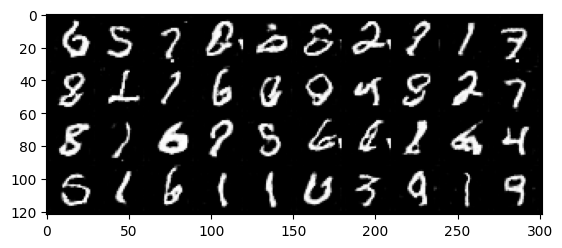

In [12]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.utils import save_image

# Assuming z_dim is the noise dimension used during training, for example, 64
z_dim = 64

# Instantiate the generator
generator = Generator(z_dim=z_dim)

generator.load_state_dict(torch.load('generator_epoch_saved_weights/generator_epoch_49.pth')) # If you have saved model weights from training, load them
generator.eval() # Set the generator to evaluation mode

# Function to create noise vectors
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

# Lock the random seed for reproducibility
random_seed = 57
torch.manual_seed(random_seed)

# Generate Noise Vectors
num_images = 40  # Number of images you want to generate
noise_vectors = get_noise(num_images, z_dim, device='cpu')

# Generate Images
with torch.no_grad():  # No need to compute gradients for generating images
    generated_images = generator(noise_vectors)

# Visualize and Save Generated Images
def show_tensor_images(image_tensor, num_images=20, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2  # De-normalize images to range [0, 1]
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = torchvision.utils.make_grid(image_unflat[:num_images], nrow=10)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

    # Save each image separately
    for i in range(num_images):
        save_image(image_unflat[i], f'dcgan_generated_images/generated_image_{i}.png')

show_tensor_images(generated_images, num_images)

# Variational Autoencoder (VAE)

Check out the sister of the GAN: VAE. In this lab, you'll explore the components of a basic VAE to understand how it works. 

The "AE" in VAE stands for autoencoder. As an autoencoder, the VAE has two parts: an encoder and a decoder. Instead of mapping each image to a single point in $z$-space, the encoder outputs the means and covariance matrices of a multivariate normal distribution where all of the dimensions are independent. You should have had a chance to read more about multivariate normal distributions in last week's assignment, but you can think of the output of the encoder of a VAE this way: the means and standard deviations of a set of independent normal distributions, with one normal distribution (one mean and standard deviation) for each latent dimension. 

![VAE Architecture](https://drive.google.com/uc?id=1Itz5Hqvl6MuzhLS00U14AM_SzlCDOmKf)
*VAE Architecture Drawing: The encoding outputs a distribution in $z$-space, and to generate an image you sample from the distributon and pass the $z$-space sample to the decoder, which returns an image. VAE latent space visualization from [Hyperspherical Variational Auto-Encoders](https://arxiv.org/abs/1804.00891)*, by Davidson et al. in UAI 2018 

## Encoder and Decoder

For your encoder and decoder, you can use similar architectures that you've seen before, with some tweaks. For example, for the decoder, you can use the DCGAN generator architecture. For the encoder, you can use a classifier that you used before, and instead of having it produce 1 classification output of whether something is a cat or not, for example, you can have it produce 2 different outputs, one for mean and one for standard deviation. Each of those outputs will have dimensionality $z$ to model the $z$ dimensions in the multivariate normal distributions.

In [13]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    '''
    Encoder Class
    Values:
    im_chan: the number of channels of the output image, a scalar
            MNIST is black-and-white (1 channel), so that's our default.
    hidden_dim: the inner dimension, a scalar
    '''

    def __init__(self, im_chan=1, output_chan=32, hidden_dim=16):
        super(Encoder, self).__init__()
        self.z_dim = output_chan
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, output_chan * 2, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a encoder block of the VAE, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation
        Parameters:
        input_channels: how many channels the input feature representation has
        output_channels: how many channels the output feature representation should have
        kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
        stride: the stride of the convolution
        final_layer: whether we're on the final layer (affects activation and batchnorm)
        '''        
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the Encoder: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
        image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        encoding = disc_pred.view(len(disc_pred), -1)
        # The stddev output is treated as the log of the variance of the normal 
        # distribution by convention and for numerical stability
        return encoding[:, :self.z_dim], encoding[:, self.z_dim:].exp()

class Decoder(nn.Module):
    '''
    Decoder Class
    Values:
    z_dim: the dimension of the noise vector, a scalar
    im_chan: the number of channels of the output image, a scalar
            MNIST is black-and-white, so that's our default
    hidden_dim: the inner dimension, a scalar
    '''
    
    def __init__(self, z_dim=32, im_chan=1, hidden_dim=64):
        super(Decoder, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a Decoder block of the VAE, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation
        Parameters:
        input_channels: how many channels the input feature representation has
        output_channels: how many channels the output feature representation should have
        kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
        stride: the stride of the convolution
        final_layer: whether we're on the final layer (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Sigmoid(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the Decoder: Given a noise vector, 
        returns a generated image.
        Parameters:
        noise: a noise tensor with dimensions (batch_size, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

# VAE

You can define the VAE using the encoder and decoder as follows. In the forward pass, the VAE samples from the encoder's output distribution before passing a value to the decoder. A common mistake is to pass the mean to the decoder --- this leads to blurrier images and is not the way in which VAEs are designed to be used. So, the steps you'll take are:

1.   Real image input to encoder
2.   Encoder outputs mean and standard deviation
3.   Sample from distribution with the outputed mean and standard deviation
4.   Take sampled value (vector/latent) as the input to the decoder
5.   Get fake sample
6.   Use reconstruction loss between the fake output of the decoder and the original real input to the encoder (more about this later - keep reading!)
7.   Backpropagate through



![VAE Architecture](https://drive.google.com/uc?id=1FNF8lPu5VoAaxS_x_2tWWSMHwLA6pjzA)

## Quick Note on Implementation Notation ("Reparameterization Trick")
Most machine learning frameworks will not backpropagate through a random sample (Step 3-4 above work in the forward pass, but its gradient is not readily implemented for the backward pass using the usual notation). In PyTorch, you can do this by sampling using the `rsample` method, such as in `Normal(mean, stddev).rsample()`. This is equivalent to `torch.randn(z_dim) * stddev + mean`, but **do not use** `torch.normal(mean, stddev)`, as the optimizer will not backpropagate through the expectation of that sample. This is also known as the reparameterization trick, since you're moving the parameters of the random sample outside of the the function to explicitly highlight that the gradient should be calculated through these parameters.

In [14]:
from torch.distributions.normal import Normal

class VAE(nn.Module):
    '''
    VAE Class
    Values:
    z_dim: the dimension of the noise vector, a scalar
    im_chan: the number of channels of the output image, a scalar
            MNIST is black-and-white, so that's our default
    hidden_dim: the inner dimension, a scalar
    '''
    
    def __init__(self, z_dim=32, im_chan=1, hidden_dim=64):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.encode = Encoder(im_chan, z_dim)
        self.decode = Decoder(z_dim, im_chan)

    def forward(self, images):
        '''
        Function for completing a forward pass of the Decoder: Given a noise vector, 
        returns a generated image.
        Parameters:
        images: an image tensor with dimensions (batch_size, im_chan, im_height, im_width)
        Returns:
        decoding: the autoencoded image
        q_dist: the z-distribution of the encoding
        '''
        q_mean, q_stddev = self.encode(images)
        q_dist = Normal(q_mean, q_stddev)
        z_sample = q_dist.rsample() # Sample once from each distribution, using the `rsample` notation
        decoding = self.decode(z_sample)
        return decoding, q_dist

## Evidence Lower Bound (ELBO)

When training a VAE, you're trying to maximize the likelihood of the real images. What this means is that you'd like the learned probability distribution to think it's likely that a real image (and the features in that real image) occurs -- as opposed to, say, random noise or weird-looking things. And you want to maximize the likelihood of the real stuff occurring and appropriately associate it with a point in the latent space distribution prior $p(z)$ (more on this below), which is where your learned latent noise vectors will live. However, finding this likelihood explicitly is mathematically intractable. So, instead, you can get a good lower bound on the likelihood, meaning you can figure out what the worst-case scenario of the likelihood is (its lower bound which *is* mathematically tractable) and try to maximize that instead. Because if you maximize its lower bound, or worst-case, then you probably are making the likelihood better too. And this neat technique is known as maximizing the Evidence Lower Bound (ELBO).

Some notation before jumping into explaining ELBO: First, the prior latent space distribution $p(z)$ is the prior probability you have on the latent space $z$. This represents the likelihood of a given latent point in the latent space, and you know what this actually is because you set it in the beginning as a multivariate normal distribution. Additionally, $q(z)$ refers to the posterior probability, or the distribution of the encoded images. Keep in mind that when each image is passed through the encoder, its encoding is a probability distribution.

Knowing that notation, here's the mathematical notation for the ELBO of a VAE, which is the lower bound you want to maximize: $\mathbb{E}\left(\log p(x|z)\right) + \mathbb{E}\left(\log \frac{p(z)}{q(z)}\right)$, which is equivalent to $\mathbb{E}\left(\log p(x|z)\right) - \mathrm{D_{KL}}(q(z|x)\Vert p(z))$

ELBO can be broken down into two parts: the reconstruction loss $\mathbb{E}\left(\log p(x|z)\right)$ and the KL divergence term $\mathrm{D_{KL}}(q(z|x)\Vert p(z))$. You'll explore each of these two terms in the next code and text sections.

### Reconstruction Loss 

Reconstruction loss refers to the distance between the real input image (that you put into the encoder) and the generated image (that comes out of the decoder). Explicitly, the reconstruction loss term is $\mathbb{E}\left(\log p(x|z)\right)$, the log probability of the true image given the latent value. 

For MNIST, you can treat each grayscale prediction as a binary random variable (also known as a Bernoulli distribution) with the value between 0 and 1 of a pixel corresponding to the output brightness, so you can use the binary cross entropy loss between the real input image and the generated image in order to represent the reconstruction loss term. 

In general, different assumptions about the "distribution" of the pixel brightnesses in an image will lead to different loss functions. For example, if you assume that the brightnesses of the pixels actually follow a normal distribution instead of a binary random (Bernoulli) distribution, this corresponds to a mean squared error (MSE) reconstruction loss.

Why the mean squared error? Well, as a point moves away from the center, $\mu$, of a normal distribution, its negative log likelihood increases quadratically. You can also write this as $\mathrm{NLL}(x) \propto (x-\mu)^2$ for $x \sim \mathcal{N}(\mu,\sigma)$. As a result, assuming the pixel brightnesses are normally distributed implies an MSE reconstruction loss. 

In [15]:
reconstruction_loss = nn.BCELoss(reduction='sum')

### KL Divergence 

KL divergence, mentioned in a video (on Inception Score) last week, allows you to evaluate how different one probability distribution is from another. If you have two distributions and they are exactly the same, then KL divergence is equal to 0. KL divergence is close to the notion of distance between distributions, but notice that it's called a divergence, not a distance; this is because it is not symmetric, meaning that $\mathrm{KL}(X\Vert Y)$ is usually not equal to the terms flipped $\mathrm{KL}(Y\Vert X)$. In contrast, a true distance function, like the Euclidean distance where you would take the squared difference between two points, is symmetric where you compare $(A-B)^2$ and $(B-A)^2$. 

Now, you care about two distributions and finding how different they are: (1) the learned latent space $q(z|x)$ that your encoder is trying to model and (2) your prior on the latent space $p(z)$, which you want your learned latent space to be as close as possible to. If both of your distributions are normal distributions, you can calculate the KL divergence, or $\mathrm{D_{KL}}(q(z|x)\Vert p(z))$, based on a simple formula. This makes KL divergence an attractive measure to use and the normal distribution a simultaneously attractive distribution to assume on your model and data. 

Well, your encoder is learning $q(z|x)$, but what's your latent prior $p(z)$? It is actually a fairly simple distribution for the latent space with a mean of zero and a standard deviation of one in each dimension, or $\mathcal{N}(0, I)$. You might also come across this as the *spherical normal distribution*, where the $I$ in $\mathcal{N}(0, I)$ stands for the identity matrix, meaning its covariance is 1 along the entire diagonal of the matrix and if you like geometry, it forms a nice symmetric-looking hypersphere, or a sphere with many (here, $z$) dimensions.

In [16]:
from torch.distributions.kl import kl_divergence
def kl_divergence_loss(q_dist):
    return kl_divergence(
        q_dist, Normal(torch.zeros_like(q_dist.mean), torch.ones_like(q_dist.stddev))
    ).sum(-1)

### Further Resources

An accessible but complete discussion and derivation of the evidence lower bound (ELBO) and the theory behind it can be found [at this link](https://deepgenerativemodels.github.io/notes/vae/) and [this lecture](http://www.cs.toronto.edu/~rgrosse/courses/csc421_2019/slides/lec17.pdf).

## Training a VAE

Here you can train a VAE, once again using MNIST! First, define the dataloader:

In [280]:
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms

vae_transform=transforms.Compose([
    transforms.ToTensor(),
])
mnist_dataset = datasets.MNIST('.', train=True, transform=vae_transform)
train_dataloader = DataLoader(mnist_dataset, shuffle=True, batch_size=1024)

In [281]:
train_dataloader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

Then, you can run the training loop to observe the training process:

In [282]:
# import torch
# import os
# import matplotlib.pyplot as plt
# from torchvision.utils import make_grid
# from tqdm import tqdm
# import time

# # Define the file path to save the generator weights
# def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
#     '''
#     Function for visualizing images: Given a tensor of images, number of images, and
#     size per image, plots and prints the images in an uniform grid.
#     '''
#     image_unflat = image_tensor.detach().cpu()
#     image_grid = make_grid(image_unflat[:num_images], nrow=5)
#     plt.axis('off')
#     plt.imshow(image_grid.permute(1, 2, 0).squeeze())

# # Directory to save model weights
# save_dir = 'model_weights'
# os.makedirs(save_dir, exist_ok=True)

# device = 'cpu'
# vae = VAE().to(device)
# vae_opt = torch.optim.Adam(vae.parameters(), lr=0.002)

# for epoch in range(10):
#     print(f"Epoch {epoch}")
#     time.sleep(0.5)
#     for images, _ in tqdm(train_dataloader):
#         images = images.to(device)
#         vae_opt.zero_grad()  # Clear out the gradients
#         recon_images, encoding = vae(images)
#         loss = reconstruction_loss(recon_images, images) + kl_divergence_loss(encoding).sum()
#         loss.backward()
#         vae_opt.step()
    
#     # Save model weights
#     torch.save(vae.state_dict(), os.path.join(save_dir, f'vae_epoch_{epoch}.pth'))
    
#     plt.subplot(1, 2, 1)
#     show_tensor_images(images)
#     plt.title("True")
#     plt.subplot(1, 2, 2)
#     show_tensor_images(recon_images)
#     plt.title("Reconstructed")
#     plt.show()

In [283]:
import torchvision
from torchvision.utils import save_image


# Function to sample from the latent space
def sample_latent_space(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

# Function to visualize and save images
def show_tensor_images(image_tensor, num_images=20, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2  # De-normalize images to range [0, 1]
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = torchvision.utils.make_grid(image_unflat[:num_images], nrow=10)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
    plt.show()

    # Save each image separately
    for i in range(num_images):
        save_image(image_unflat[i], f'vae_generated_images/generated_image_{i}.png')

# Load the trained VAE model
z_dim = 32
vae = VAE(z_dim=z_dim)
vae.load_state_dict(torch.load('vae_model_saved_weights/vae_epoch_9.pth'))  # Update the path as needed
vae.eval()  # Set the VAE to evaluation mode

# Lock the random seed for reproducibility
random_seed = 19
torch.manual_seed(random_seed)

# Sample from the latent space
num_images = 40  # Number of images you want to generate
latent_vectors = sample_latent_space(num_images, z_dim, device='cpu')

# Generate images
with torch.no_grad():  # No need to compute gradients for generating images
    generated_images = vae.decode(latent_vectors)

# Create the directory for saving generated images if it does not exist
os.makedirs('vae_generated_images', exist_ok=True)

# Show and save the generated images
show_tensor_images(generated_images, num_images=num_images)

NameError: name 'VAE' is not defined

Changes made:
- Using Conv2D instead of Conv3D because we're using 2D images (MNIST images) not video frames of volumetric data.

## 1. **Imports**

In [89]:
import numpy as np
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt

## 2. **Get MNIST data**

In [90]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
x_train = x_train.astype('float32') / 255 # because the images are in the form of lists
x_test = x_test.astype('float32') / 255

# Reshape the data to add channel dimension
x_train = np.expand_dims(x_train, axis=-1)  # Shape: (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1)    # Shape: (10000, 28, 28, 1)

# One-hot encode the labels
# y_train = to_categorical(y_train, 10) # the 10 at the end is the number of classes there are in the dataset
# y_test = to_categorical(y_test, 10)

In [91]:
# Function to print class distributions
def print_class_distribution(y, dataset_name):
    classes_dict = dict()
    print(f"{dataset_name} DATASET")
    for i in range(10):  # Assuming 10 classes, adjust if necessary
        i_idx = np.where(y == i)
        i_nums = y[i_idx]
        print(f"There are {len(i_nums)} instance(s) of class {i}")
        classes_dict[i] = len(i_nums)

    return classes_dict

# Print class distributions for both datasets
y_train_class_dist = print_class_distribution(y_train, "TRAIN")
print()
y_test_class_dist = print_class_distribution(y_test, "TEST")

TRAIN DATASET
There are 5923 instance(s) of class 0
There are 6742 instance(s) of class 1
There are 5958 instance(s) of class 2
There are 6131 instance(s) of class 3
There are 5842 instance(s) of class 4
There are 5421 instance(s) of class 5
There are 5918 instance(s) of class 6
There are 6265 instance(s) of class 7
There are 5851 instance(s) of class 8
There are 5949 instance(s) of class 9

TEST DATASET
There are 980 instance(s) of class 0
There are 1135 instance(s) of class 1
There are 1032 instance(s) of class 2
There are 1010 instance(s) of class 3
There are 982 instance(s) of class 4
There are 892 instance(s) of class 5
There are 958 instance(s) of class 6
There are 1028 instance(s) of class 7
There are 974 instance(s) of class 8
There are 1009 instance(s) of class 9


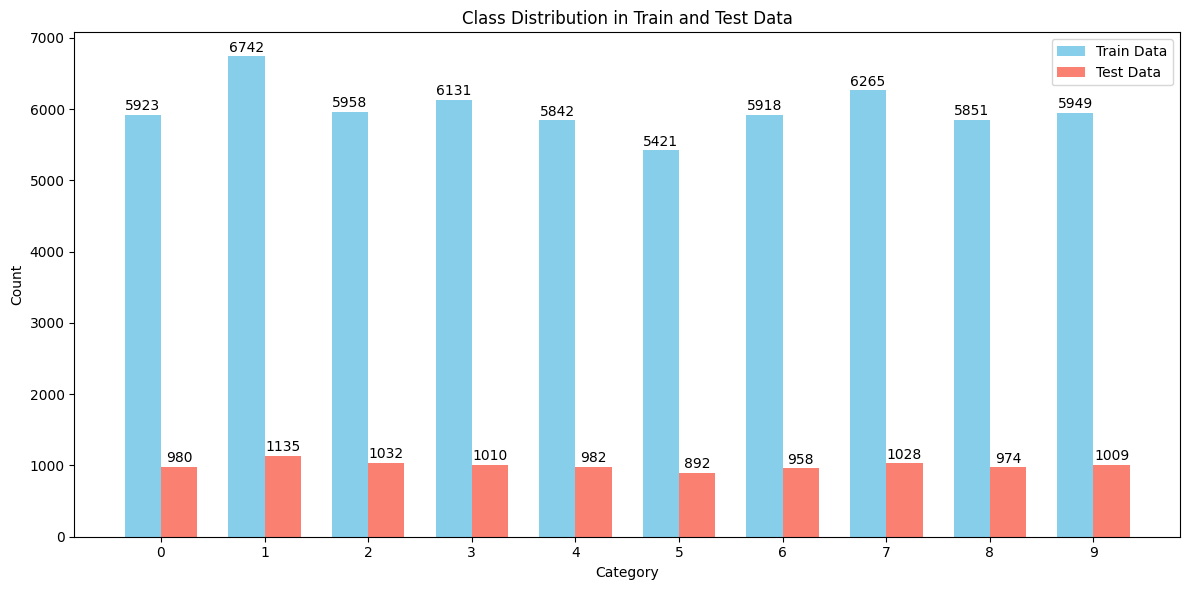

In [92]:
import matplotlib.pyplot as plt
import numpy as np


# Extract keys and values
keys = list(y_train_class_dist.keys())
train_values = [y_train_class_dist[k] for k in keys]
test_values = [y_test_class_dist[k] for k in keys]

# Set the width of the bars
bar_width = 0.35

# Define positions of the bars on the x-axis
index = np.arange(len(keys))

# Create the plot
plt.figure(figsize=(12, 6))

# Plot train data
plt.bar(index - bar_width/2, train_values, bar_width, color='skyblue', label='Train Data')

# Plot test data
plt.bar(index + bar_width/2, test_values, bar_width, color='salmon', label='Test Data')

# Set labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Class Distribution in Train and Test Data')
plt.xticks(index, [str(key) for key in keys])
plt.legend()

# Optionally, add value labels on top of bars
for i, value in enumerate(train_values):
    plt.text(index[i] - bar_width/2, value + 25, str(value), ha='center', va='bottom')
for i, value in enumerate(test_values):
    plt.text(index[i] + bar_width/2, value + 25, str(value), ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

In [93]:
import numpy as np

# Set the random seed for reproducibility
np.random.seed(42)

def handle_class_imb(x, y, target_num_samples_per_class):
    """
    Handle class imbalance by shuffling and reducing the number of samples per class.

    Args:
        x (numpy.ndarray): Features array.
        y (numpy.ndarray): Labels array.
        target_num_samples_per_class (int): Number of samples to retain per class.

    Returns:
        Tuple: (x_new, y_new) with balanced number of samples for each class.
    """
    unique_classes = np.unique(y)
    x_new_list = []
    y_new_list = []

    for cls in unique_classes:
        # Get indices of samples belonging to the current class
        class_indices = np.where(y == cls)[0]

        # Shuffle the indices
        np.random.shuffle(class_indices)

        # Select the first 'target_num_samples_per_class' samples
        selected_indices = class_indices[:target_num_samples_per_class]

        # Append the selected samples to the new lists
        x_new_list.append(x[selected_indices])
        y_new_list.append(y[selected_indices])

    # Concatenate the lists to form the final arrays
    x_new = np.concatenate(x_new_list)
    y_new = np.concatenate(y_new_list)

    # one hot encode labels
    y_new = to_categorical(y_new, 10)

    # Shuffle indices
    indices = np.arange(len(x_new)) # create indices
    shuffled_idx = np.random.permutation(indices) # shuffle indices
    x_shuffled, y_shuffled = x_new[shuffled_idx], y_new[shuffled_idx]
    

    return x_shuffled, y_shuffled

# Example usage:
# Assuming x_train and y_train are your feature and label arrays
target_for_train = min(train_values) # Adjust as needed
target_for_test = min(test_values) # Adjust as needed

x_train, y_train = handle_class_imb(x_train, y_train, target_for_train)
x_test, y_test = handle_class_imb(x_test, y_test, target_for_test)

In [94]:
argmax_for_each_row = np.argmax(y_train, axis = 1)
mask = (argmax_for_each_row == 0)
# Filter the rows where argmax is 0
filtered_rows = y_train[mask]
# Print or inspect the filtered rows
len(filtered_rows)

5421

In [95]:
import numpy as np

# Function to print class distributions
def print_class_distribution(y, dataset_name):
    classes_dict = dict()
    print(f"{dataset_name} DATASET")
    
    # Convert all rows to the class number instead of one-hot encoded
    class_as_num = np.argmax(y, axis=1)

    

    for i in range(10):
        i_idx = np.where(class_as_num == i)[0]  # Get indices where class_as_num equals i, returns a singelton around the array
        print(f"There are {len(i_idx)} instance(s) of class {i}")
        classes_dict[i] = len(i_idx)

    return classes_dict


# Print class distributions for both datasets
y_train_class_dist = print_class_distribution(y_train, "TRAIN")
print()
y_test_class_dist = print_class_distribution(y_test, "TEST")  

TRAIN DATASET
There are 5421 instance(s) of class 0
There are 5421 instance(s) of class 1
There are 5421 instance(s) of class 2
There are 5421 instance(s) of class 3
There are 5421 instance(s) of class 4
There are 5421 instance(s) of class 5
There are 5421 instance(s) of class 6
There are 5421 instance(s) of class 7
There are 5421 instance(s) of class 8
There are 5421 instance(s) of class 9

TEST DATASET
There are 892 instance(s) of class 0
There are 892 instance(s) of class 1
There are 892 instance(s) of class 2
There are 892 instance(s) of class 3
There are 892 instance(s) of class 4
There are 892 instance(s) of class 5
There are 892 instance(s) of class 6
There are 892 instance(s) of class 7
There are 892 instance(s) of class 8
There are 892 instance(s) of class 9


These are the results for a model without any data augmentation, do it again:
- with data aug
- with GAN
- with VAE

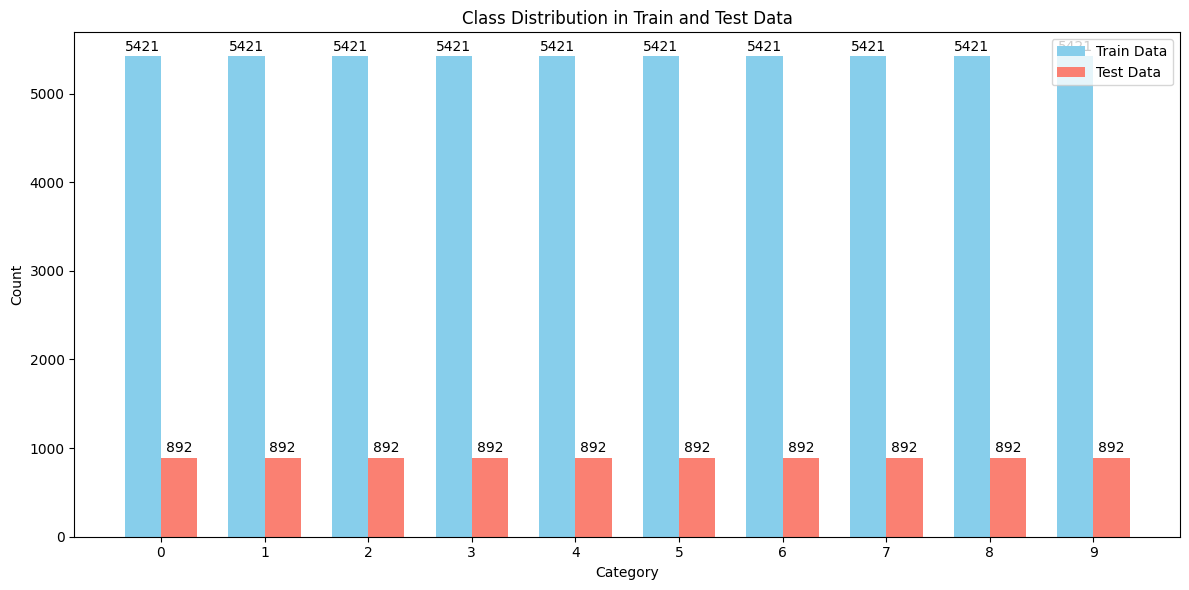

In [96]:
import matplotlib.pyplot as plt
import numpy as np


# Extract keys and values
keys = list(y_train_class_dist.keys())
train_values = [y_train_class_dist[k] for k in keys]
test_values = [y_test_class_dist[k] for k in keys]

# Set the width of the bars
bar_width = 0.35

# Define positions of the bars on the x-axis
index = np.arange(len(keys))

# Create the plot
plt.figure(figsize=(12, 6))

# Plot train data
plt.bar(index - bar_width/2, train_values, bar_width, color='skyblue', label='Train Data')

# Plot test data
plt.bar(index + bar_width/2, test_values, bar_width, color='salmon', label='Test Data')

# Set labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Class Distribution in Train and Test Data')
plt.xticks(index, [str(key) for key in keys])
plt.legend()

# Optionally, add value labels on top of bars
for i, value in enumerate(train_values):
    plt.text(index[i] - bar_width/2, value + 25, str(value), ha='center', va='bottom')
for i, value in enumerate(test_values):
    plt.text(index[i] + bar_width/2, value + 25, str(value), ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

In [97]:
import tensorflow as tf
import cv2
import os
import numpy as np

def crop_to_subject(image):
    # Convert the image to grayscale if it isn't already
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Find the bounding box of the non-zero pixels
    non_zero_pixels = np.argwhere(gray > 0)
    if non_zero_pixels.size == 0:
        # If the image is entirely black, return the original image
        return image

    x0, y0 = non_zero_pixels.min(axis=0)
    x1, y1 = non_zero_pixels.max(axis=0) + 1  # slices are exclusive at the top

    # Crop the image using the bounding box coordinates
    cropped = gray[x0:x1, y0:y1]

    cropped = cv2.resize(cropped, (28, 28), interpolation=cv2.INTER_AREA)

    return cropped

# Convert labels to ohe
def one_hot_encode(labels, num_classes=None):
    if num_classes is None:
        num_classes = max(labels) + 1
    return tf.keras.utils.to_categorical(labels, num_classes)

def remove_entirely_black_images(x_train, y_train):
    # Find indices of images that are entirely black
    black_image_indices = np.where(np.all(x_train == 0, axis=(1, 2)))[0]

    print("Indices of entirely black images:", black_image_indices)

    # Create a mask to select all images except the black ones
    mask = np.ones(len(x_train), dtype=bool)
    mask[black_image_indices] = False

    # Filter out the black images
    x_train_filtered = x_train[mask]
    y_train_filtered = y_train[mask]

    print("Entirely black images have been removed successfully!")

    return x_train_filtered, y_train_filtered


class DataHandler:
  def __init__(self, image_height, image_width, channels):
    self.image_height = image_height
    self.image_width = image_width
    self.channels = channels
    self.original_train_data = None
    self.original_test_data = None
    self.augmented_train_data = None
    self.dcgan_train_data = None
    self.vae_train_data = None

  def load_data(self, x_train, y_train, x_test, y_test):
    x_train_filtered, y_train_filtered = remove_entirely_black_images(x_train, y_train)
    x_test_filtered, y_test_filtered = remove_entirely_black_images(x_test, y_test)

    num_datapoints = 1100

    # Only use a subset of the original data, so that the generated images can be a larger percentage of the overall dataset size
    x_train_subset, y_train_subset = x_train_filtered[:num_datapoints], y_train_filtered[:num_datapoints]
    x_test_subset, y_test_subset = x_test_filtered[:num_datapoints], y_test_filtered[:num_datapoints]

    self.original_train_data = (x_train_subset, y_train_subset)
    self.original_test_data = (x_test_subset, y_test_subset)

  def augment_data(self, num_samples=100, reset_before_augment=False):
    if reset_before_augment:
        print('Augmented data list was reset before augmenting.')
        self.augmented_train_data = None

    if self.original_train_data is None:
        print("Error: No original training data loaded.")
        return

    augmented_train_data = []
    augmented_train_labels = []

    original_images, original_labels = self.original_train_data

    # Ensure num_samples does not exceed the size of original data
    num_samples = min(num_samples, len(original_images))

    # Transform and collect augmented data
    for i in range(num_samples):
        image, label = original_images[i], original_labels[i]
        # Transformations: Shift the image along the x and y axis
        shifted = cv2.warpAffine(image, np.float32([[1, 0, np.random.randint(-30, 30)], [0, 1, np.random.randint(-30, 30)]]), (image.shape[1], image.shape[0]))
        # Resize Image
        image_resized = crop_to_subject(shifted)
        # The image currently has 2 dimensions 28 x 28, but it needs to be 28 x 28 x 1 to match the original dataset
        expanded_image = np.expand_dims(image_resized, axis=-1) # the -1 inserts the new dimension at the end of the shape.
        # Add transformed image + label to augmented training data
        augmented_train_data.append(expanded_image)
        augmented_train_labels.append(label)

    self.augmented_train_data = (np.array(augmented_train_data), np.array(augmented_train_labels)) # results in something like this [(img1, label1), (img2, label2)]
    print('Data has been augmented')

  def add_gen_images(self, gen_images, gen_labels, num_samples, gen_type):
    if gen_type == 'dcgan':
        train_data_to_update = self.dcgan_train_data
    elif gen_type == 'vae':
        train_data_to_update = self.vae_train_data
    else:
        print("Error: Unsupported generation type. Use 'dcgan' or 'vae'.")
        return

    if train_data_to_update == None: 
      # This is how the data is stored --> self.original_train_data = (x_train, y_train)
      x_train_og, y_train_og = self.original_train_data

      # If the number of dcgan images don't reach the num of samples desired produce duplicates until we reach target num 
      goal_num = max(len(gen_images), num_samples)
      
      repeated_images = []
      repeated_labels = []


      for image, label in zip(gen_images, gen_labels):
        # Append each one to the list   
        repeated_images.append(image)
        repeated_labels.append(label)

      
      # Ensure images and labels are all numpy arrays so we can combine them
      repeated_images = np.array(repeated_images)
      repeated_labels = np.array(one_hot_encode(repeated_labels))

      # Combine the original and DCGAN data
      x_train_combined = np.concatenate((x_train_og, repeated_images), axis=0)
      y_train_combined = np.concatenate((y_train_og, repeated_labels), axis=0)

      # Update the dcgan_train_data with the combined data
      # Update the appropriate data attribute
      if gen_type == 'dcgan':
          self.dcgan_train_data = (x_train_combined, y_train_combined)
      elif gen_type == 'vae':
          self.vae_train_data = (x_train_combined, y_train_combined)

      print(f'{gen_type.upper()} data has been added to the training data.')
    else:
      print(f'{gen_type.upper()} data has already been added to the original training data.')

  # Getters
  def get_original_train_data(self):
    return self.original_train_data

  def get_original_test_data(self):
    return self.original_test_data

  def get_augmented_train_data(self):
    return self.augmented_train_data

  def get_train_and_augmented_data(self):
    if self.original_train_data is None or self.augmented_train_data is None:
        print("Error: Original or augmented train data not loaded.")
        return None 
    
    # Get the imgs and labels
    original_data, original_labels = self.original_train_data
    augmented_data, augmented_labels = self.augmented_train_data

    # Concatenate the original and augmented data
    combined_data = np.concatenate((original_data, augmented_data), axis=0)
    combined_labels = np.concatenate((original_labels, augmented_labels), axis=0)

    return combined_data, combined_labels

  def get_train_and_dcgan_data(self): 
     return self.dcgan_train_data

  def get_train_and_vae_data(self): 
     return self.vae_train_data

Indices of entirely black images: []
Entirely black images have been removed successfully!
Indices of entirely black images: []
Entirely black images have been removed successfully!


Text(0.5, 1.0, '3')

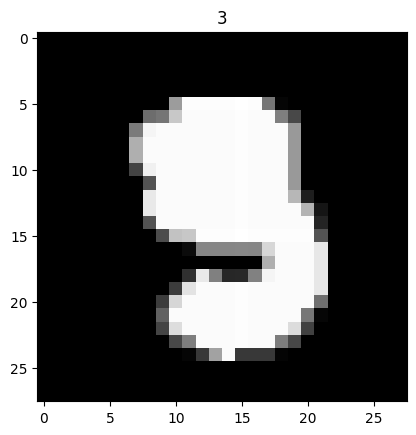

In [98]:
data_handler = DataHandler(28, 28, 1)
# load data
data_handler.load_data(x_train, y_train, x_test, y_test)

# # Check out first data point
first_img = data_handler.get_original_train_data()[0][500]
first_label = data_handler.get_original_train_data()[1][500]

plt.imshow(first_img, cmap='gray')
plt.title(f'{first_label.tolist().index(1.0)}')

In [99]:
# augment data
data_handler.augment_data(reset_before_augment=True)

Augmented data list was reset before augmenting.
Data has been augmented


In [100]:
f"There are {len(data_handler.get_augmented_train_data()[0])} data points in the augmented training dataset."

'There are 100 data points in the augmented training dataset.'

In [101]:
f"There are {len(data_handler.get_train_and_augmented_data()[0])} data points in the augmented training dataset."

'There are 1200 data points in the augmented training dataset.'

## 2. Train model

In [102]:
x_test, y_test = data_handler.get_original_test_data()

In [103]:
# Get x_train, y_train to train model for each scenario
original_x_train, original_y_train = data_handler.get_original_train_data()
augmented_x_train, augmented_y_train = data_handler.get_train_and_augmented_data()

In [158]:
# utility function to plot the loss and accuracy for the trained model
def plot(history, plot_title):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

    # Plot categorical accuracy and validation accuracy
    axes[0].plot(history['categorical_accuracy'])
    axes[0].plot(history['val_categorical_accuracy'])
    axes[0].legend(['categorical_accuracy', 'val_categorical_accuracy'])
    axes[0].set_title('Categorical Accuracy and Validation Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].grid(True)
    
    # Plot loss and validation loss
    axes[1].plot(history['loss'])
    axes[1].plot(history['val_loss'])
    axes[1].legend(['loss', 'val_loss'])
    axes[1].set_title('Loss and Validation Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].grid(True)
    
    # Adding more ticks
    axes[0].set_xticks(np.arange(0, 110, step=10))
    axes[0].set_yticks(np.arange(0, 1.1, step=0.1))
    
    # Adding more ticks
    axes[1].set_xticks(np.arange(0, 110, step=10))
    axes[1].set_yticks(np.arange(0, max(max(history['loss']), max(history['val_loss'])) + 0.1, step=0.5))

    # Setting the overall title for the entire figure
    fig.suptitle(plot_title, fontsize=16)

    # Adjust layout to make room for the super title
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    
    plt.show()



In [105]:
from tensorflow.keras.metrics import Precision, Recall

"""
Changes made to the architecture of the model:
 - Third dimension of the filters were removed as there was no longer a time dimension
 - More metrics were added
"""

class ModelConv2D10:
    def __init__(self):
        self.image_height = 28
        self.image_width = 28
        self.channels = 1
        self.num_classes = 10

    def define_model(self,filtersize=(3,3),dense_neurons=64,dropout=0.25):
        model = Sequential()
        model.add(Conv2D(16, filtersize, padding='same',
                 input_shape=(self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam(learning_rate=0.0002)
        # Compile the model with multiple metrics
        model.compile(
            optimizer=optimiser,
            loss='categorical_crossentropy',
            metrics=[
                'categorical_accuracy',
                Precision(),
                Recall(),
            ]
        )       
        return model


In [106]:
"""No changes were made to the architecture of the model besides removing the third dimension of the filters as there was no longer a time dimension"""

class ModelConv2D8:
    def __init__(self):
        self.image_height = 28
        self.image_width = 28
        self.channels = 1
        self.num_classes = 10

    def define_model(self, dense_neurons=64, dropout=0.25):
        model = Sequential()
        model.add(Conv2D(8, (3, 3), padding='same',
                         input_shape=(self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(16, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(32, (2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(64, (2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = Adam(learning_rate=0.0002)
        model.compile(
            optimizer=optimiser,
            loss='categorical_crossentropy',
            metrics=[
                'categorical_accuracy',
                Precision(),
                Recall(),
            ]
        )       
        return model


### Model 8 with Orginal Data

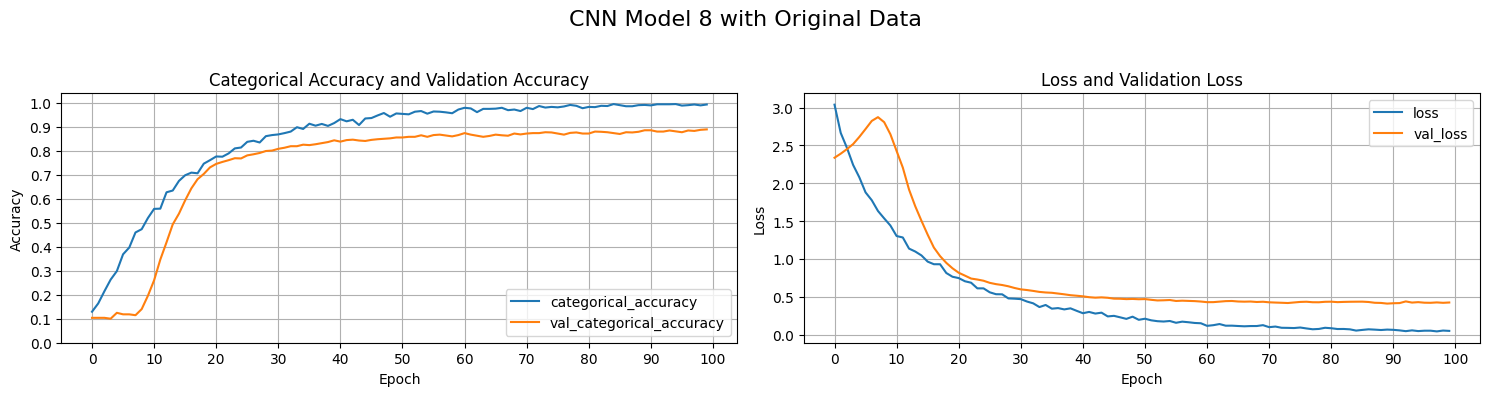

In [159]:
# # Compile the model
# conv_2d8_og_data=ModelConv2D8()
# model8_og_data = conv_2d8_og_data.define_model()
# model8_og_data.summary()

# # Train the model
# history8_og= model8_og_data.fit(original_x_train, original_y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test)) 

# # Save the entire model
# model8_og_data.save('saved_models/model8_og_data.keras')

# # Save the history object to a file
# with open('saved_histories/history8_og.json', 'w') as file:
#     json.dump(history8_og.history, file)

# Load the history object from the file
with open('saved_histories/history8_og.json', 'r') as file:
    history8_og = json.load(file)

plot(history8_og, 'CNN Model 8 with Original Data')

### 2.2 Model 10 with Original Data

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 28, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 111,690 (436.29 KB)

 Trainable params: 110,954 (433.41 KB)

 Non-trainable params: 736 (2.88 KB)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - categorical_accuracy: 0.1752 - loss: 2.8255 - precision_7: 0.2363 - recall_7: 0.0642 - val_categorical_accuracy: 0.1500 - val_loss: 2.3127 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.3555 - loss: 1.9297 - precision_7: 0.5267 - recall_7: 0.1926 - val_categorical_accuracy: 0.1064 - val_loss: 2.3564 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - categorical_accuracy: 0.4686 - loss: 1.4963 - precision_7: 0.6725 - recall_7: 0.2762 - val_categorical_accuracy: 0.1436 - val_loss: 2.4148 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - categorical_accuracy: 0.6070 - loss: 1.1727 - precision_7: 0.8003 - recall_7: 0.4090 - val_categorical_accuracy: 0.1255 - val_loss: 2.4870 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00


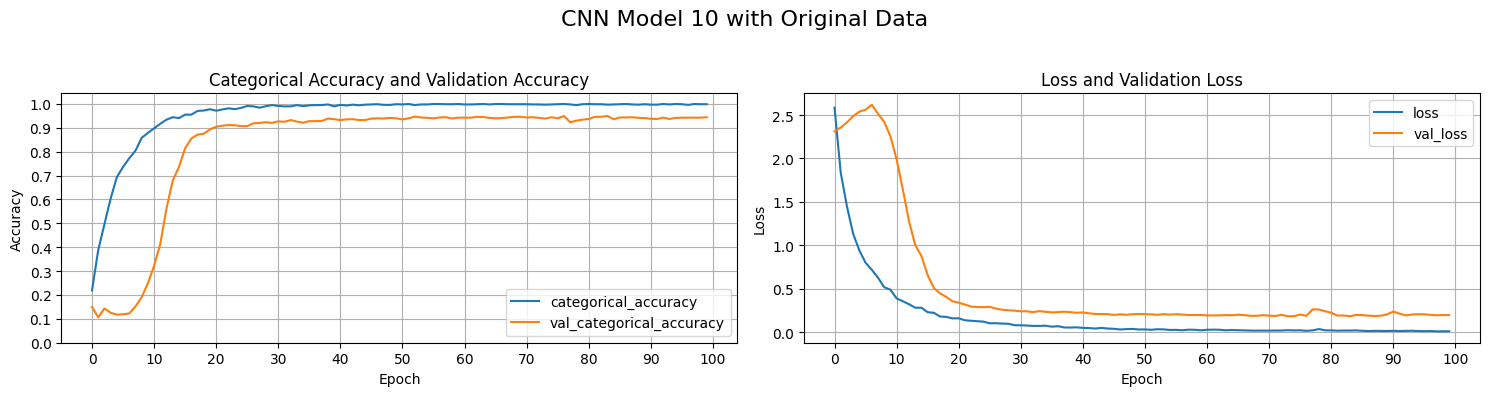

In [160]:
# Compile Model
conv_2d10_og_data = ModelConv2D10()
model10_og_data = conv_2d10_og_data.define_model()
model10_og_data.summary()

# Train Model 
history10_og = model10_og_data.fit(original_x_train, original_y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test))

# Save the entire model
model10_og_data.save('saved_models/model10_og_data.keras')

# Save the history object to a file
with open('saved_histories/history10_og.json', 'w') as file:
    json.dump(history10_og.history, file)

# Load the history object from the file
with open('saved_histories/history10_og.json', 'r') as file:
    history10_og = json.load(file)

plot(history10_og, 'CNN Model 10 with Original Data')

### 2.3 Model 8 with Augmented Data

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 28, 28, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 14, 14, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 7, 7, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 7, 7, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 3, 3, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 3, 3, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 21,546 (84.16 KB)

 Trainable params: 21,050 (82.23 KB)

 Non-trainable params: 496 (1.94 KB)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - categorical_accuracy: 0.1067 - loss: 2.9653 - precision_8: 0.1238 - recall_8: 0.0254 - val_categorical_accuracy: 0.1073 - val_loss: 2.3105 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.1587 - loss: 2.5657 - precision_8: 0.2115 - recall_8: 0.0416 - val_categorical_accuracy: 0.1000 - val_loss: 2.3273 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.2494 - loss: 2.2646 - precision_8: 0.4905 - recall_8: 0.1044 - val_categorical_accuracy: 0.0936 - val_loss: 2.3330 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.2720 - loss: 2.1168 - precision_8: 0.4820 - recall_8: 0.0988 - val_categorical_accuracy: 0.1045 - val_loss: 2.3107 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00


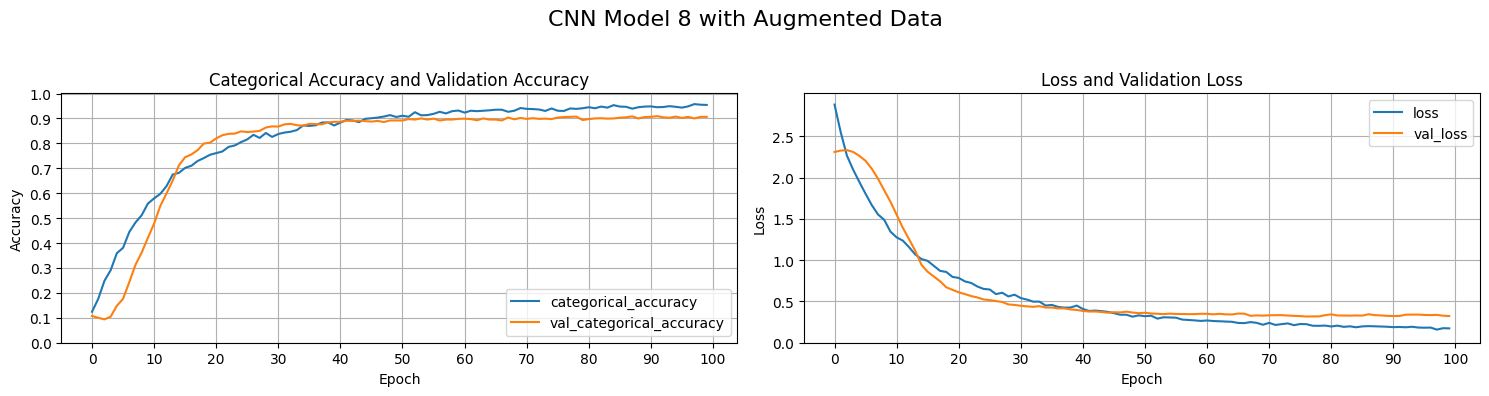

In [161]:
# Compile Model
conv_2d8_aug_data = ModelConv2D8()
model8_aug_data = conv_2d8_aug_data.define_model()
model8_aug_data.summary()

# Train Model
history8_aug = model8_aug_data.fit(augmented_x_train, augmented_y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test))

# Save the entire model
model8_aug_data.save('saved_models/model8_aug_data.keras')

# Save the history object to a file
with open('saved_histories/history8_aug.json', 'w') as file:
    json.dump(history8_aug.history, file)

# Load the history object from the file
with open('saved_histories/history8_aug.json', 'r') as file:
    history8_aug = json.load(file)

plot(history8_aug, 'CNN Model 8 with Augmented Data')

### 2.3 Model 10 with Augmented Data

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 28, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 111,690 (436.29 KB)

 Trainable params: 110,954 (433.41 KB)

 Non-trainable params: 736 (2.88 KB)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - categorical_accuracy: 0.1518 - loss: 2.9509 - precision_9: 0.1520 - recall_9: 0.0430 - val_categorical_accuracy: 0.0982 - val_loss: 2.3199 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - categorical_accuracy: 0.3398 - loss: 1.9899 - precision_9: 0.4849 - recall_9: 0.1605 - val_categorical_accuracy: 0.0982 - val_loss: 2.3628 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - categorical_accuracy: 0.5345 - loss: 1.4332 - precision_9: 0.7507 - recall_9: 0.3134 - val_categorical_accuracy: 0.1000 - val_loss: 2.4201 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - categorical_accuracy: 0.5741 - loss: 1.3521 - precision_9: 0.7548 - recall_9: 0.3946 - val_categorical_accuracy: 0.1027 - val_loss: 2.4542 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00


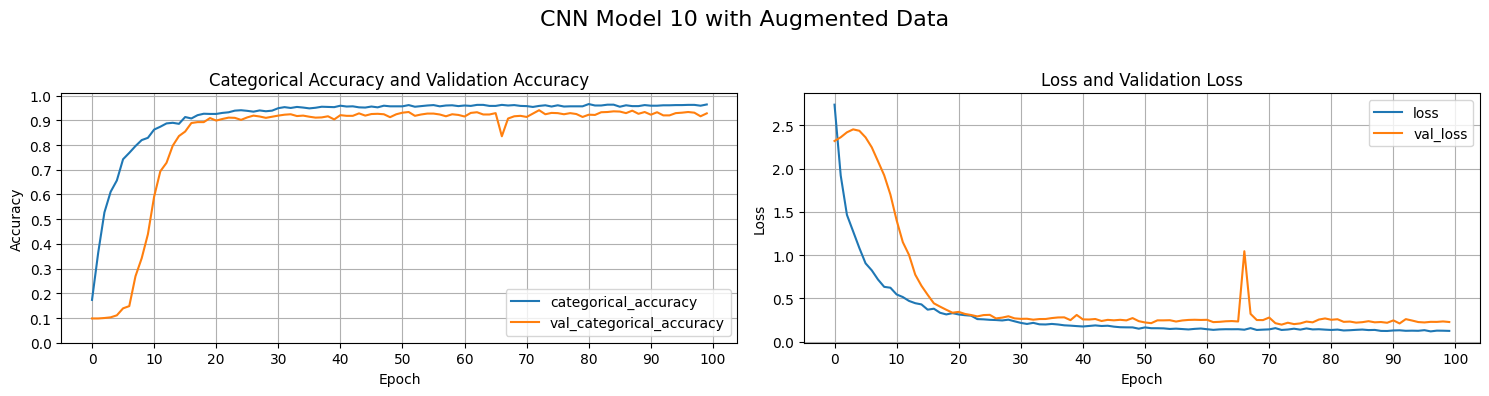

In [162]:
# Compile the model 
conv_2d10_aug_data = ModelConv2D10()
model10_aug_data = conv_2d10_aug_data.define_model()
model10_aug_data.summary()

# Train the model
history10_aug = model10_aug_data.fit(augmented_x_train, augmented_y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test))

# Save the entire model
model10_aug_data.save('saved_models/model10_aug_data.keras')

# Save the history object to a file
with open('saved_histories/history10_aug.json', 'w') as file:
    json.dump(history10_aug.history, file)

# Load the history object from the file
with open('saved_histories/history10_aug.json', 'r') as file:
    history10_aug = json.load(file)

# Plot history object
plot(history10_aug, 'CNN Model 10 with Augmented Data')


### 2.3 Model 8 with DCGAN Augmented Data

In [163]:
from PIL import Image
import numpy as np

# Step 2: Define a function to load and process generated images
def load_generated_images(folder_path):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            label = int(filename.split('.')[0])
            # Some filenames have _x where x is the version of the number in question, because each number has 10 versions
            if '_' in filename:
                label = int(str(filename).split('_')[0])  # Extract label from filename
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path).convert('L')  # Convert to grayscale
            image = image.resize((28, 28))  # Ensure image is 28x28
            image = np.array(image)  # Convert image to numpy array
            image = np.expand_dims(image, -1) # Add the channels dimension
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Step 3: Load the generated images from DCGAN
dcgan_images, dcgan_labels = load_generated_images('dcgan_generated_images')


In [164]:
# Run the method to add the images
data_handler.add_gen_images(dcgan_images, dcgan_labels, 100, 'dcgan')

DCGAN data has been added to the training data.


In [165]:
og_x, og_y = data_handler.get_original_train_data()
dcgan_x_train, dcgan_y_train = data_handler.get_train_and_dcgan_data()

print(f"Length of original dataset:{len(og_x)}. Length of dcgan augmented dataset: {len(dcgan_x_train)}")

Length of original dataset:1100. Length of dcgan augmented dataset: 1200


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 28, 28, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_41 (Activation)      │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 14, 14, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 7, 7, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_42 (Activation)      │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 7, 7, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 3, 3, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_43 (Activation)      │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 3, 3, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 21,546 (84.16 KB)

 Trainable params: 21,050 (82.23 KB)

 Non-trainable params: 496 (1.94 KB)

Epoch 1/100


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - categorical_accuracy: 0.1158 - loss: 3.0461 - precision_10: 0.1870 - recall_10: 0.0359 - val_categorical_accuracy: 0.0945 - val_loss: 2.3060 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.1148 - loss: 3.0505 - precision_10: 0.0998 - recall_10: 0.0165 - val_categorical_accuracy: 0.0945 - val_loss: 2.3137 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.1486 - loss: 2.8640 - precision_10: 0.1670 - recall_10: 0.0234 - val_categorical_accuracy: 0.0945 - val_loss: 2.3155 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.1092 - loss: 2.8067 - precision_10: 0.1176 - recall_10: 0.0181 - val_categorical_accuracy: 0.0945 - val_loss: 2.3215 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e

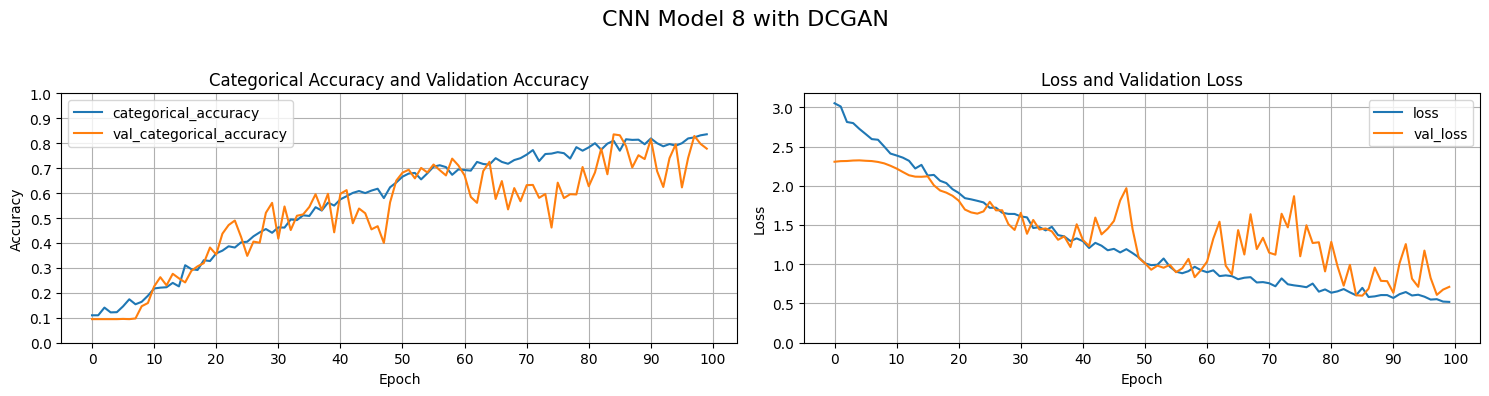

In [166]:
# Compile Model
conv_2d8_dcgan_data = ModelConv2D8()
model8_dcgan_data = conv_2d8_dcgan_data.define_model()
model8_dcgan_data.summary()

# Train model
history8_dcgan = model8_dcgan_data.fit(dcgan_x_train, dcgan_y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test))

# Save the entire model
model8_dcgan_data.save('saved_models/model8_dcgan_data.keras')

## Save the history object to a file
with open('saved_histories/history8_dcgan.json', 'w') as file:
    json.dump(history8_dcgan.history, file)

# Load the history object from the file
with open('saved_histories/history8_dcgan.json', 'r') as file:
    history8_dcgan = json.load(file)

plot(history8_dcgan, 'CNN Model 8 with DCGAN')

### Model 10 with DCGAN

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)              │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_44 (Activation)      │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 28, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_45 (Activation)      │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_46 (Activation)      │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_47 (Activation)      │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 111,690 (436.29 KB)

 Trainable params: 110,954 (433.41 KB)

 Non-trainable params: 736 (2.88 KB)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - categorical_accuracy: 0.1163 - loss: 3.0039 - precision_11: 0.1050 - recall_11: 0.0177 - val_categorical_accuracy: 0.1018 - val_loss: 2.3023 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - categorical_accuracy: 0.1388 - loss: 2.7239 - precision_11: 0.1544 - recall_11: 0.0266 - val_categorical_accuracy: 0.1036 - val_loss: 2.3047 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - categorical_accuracy: 0.1920 - loss: 2.5266 - precision_11: 0.2394 - recall_11: 0.0366 - val_categorical_accuracy: 0.1036 - val_loss: 2.3104 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - categorical_accuracy: 0.1873 - loss: 2.4437 - precision_11: 0.2632 - recall_11: 0.0504 - val_categorical_accuracy: 0.1036 - val_loss: 2.3032 - val_precision_11: 0.0000e+00 - val_recall

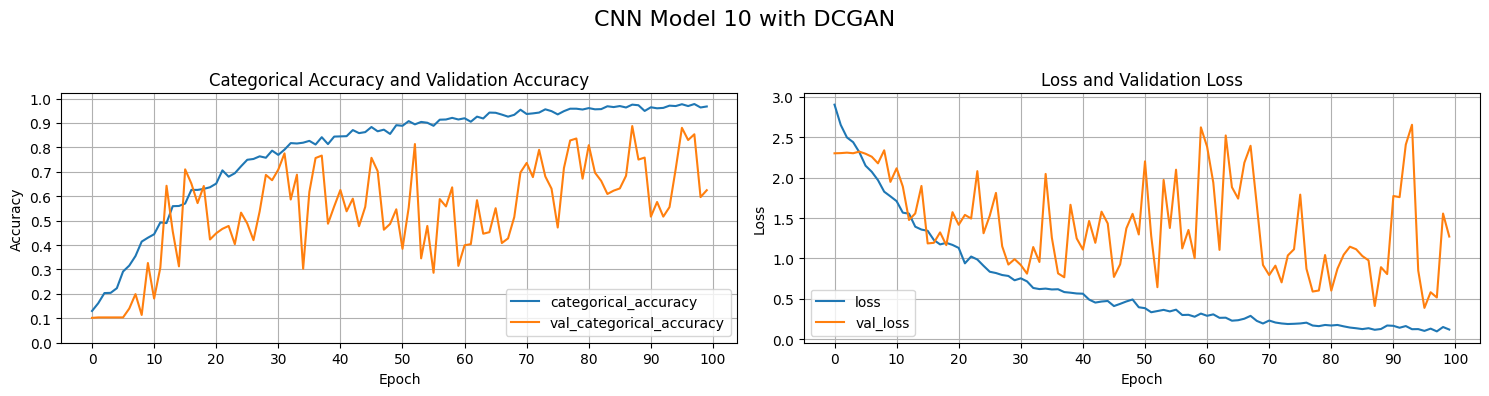

In [167]:
# Compile Model
conv_2d10_dcgan_data = ModelConv2D10()
model10_dcgan_data = conv_2d10_dcgan_data.define_model()
model10_dcgan_data.summary()

# Train Model
history10_dcgan = model10_dcgan_data.fit(dcgan_x_train, dcgan_y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test))

# Save the entire model
model10_dcgan_data.save('saved_models/model10_dcgan_data.keras')

## Save the history object to a file
with open('saved_histories/history10_dcgan.json', 'w') as file:
    json.dump(history10_dcgan.history, file)

# Load the history object from the file
with open('saved_histories/history10_dcgan.json', 'r') as file:
    history10_dcgan = json.load(file)

plot(history10_dcgan, 'CNN Model 10 with DCGAN')

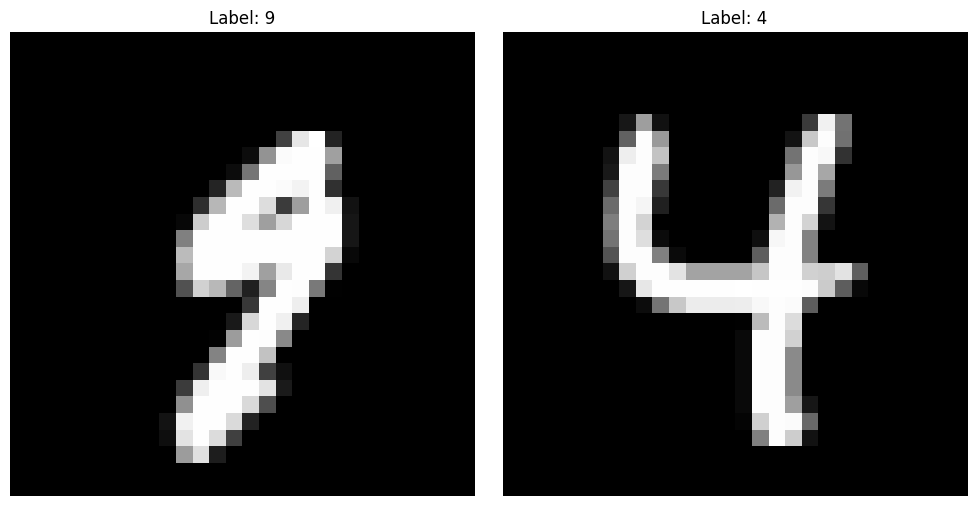

In [168]:
# Indices to display
idx = [14, 300]

# Number of images to display
num_images = len(idx)

# Create subplots
fig, axes = plt.subplots(1, num_images, figsize=(10, 5))

# Iterate through the indices and plot the images
for i, ax in enumerate(axes):
    ax.imshow(dcgan_x_train[idx[i]], cmap='gray')
    ax.set_title(f'Label: {np.argmax(dcgan_y_train[idx[i]])}')
    ax.axis('off')  # Hide the axes

plt.tight_layout()
plt.show()

There are some entirely black images, let's remove them because they're messing up the model's fitting

In [169]:
# Find indices of images that are entirely black
black_image_indices = np.where(np.all(dcgan_x_train == 0, axis=(1, 2)))[0]

print("Indices of entirely black images:", black_image_indices)
print(f"There are in total {len(black_image_indices)} of these types of images in the dataset, which is {len(black_image_indices)/len(dcgan_x_train) * 100}% of the dataset")

Indices of entirely black images: []
There are in total 0 of these types of images in the dataset, which is 0.0% of the dataset


In [170]:
# Find indices of images that are entirely black
black_image_indices = np.where(np.all(original_x_train == 0, axis=(1, 2)))[0]

print("Indices of entirely black images:", black_image_indices)
print(f"There are in total {len(black_image_indices)} of these types of images in the dataset, which is {len(black_image_indices)/len(original_x_train) * 100}% of the dataset")

Indices of entirely black images: []
There are in total 0 of these types of images in the dataset, which is 0.0% of the dataset


This is coming straight from the dataset that was loaded in from mnist, let's remove them and try again. This will be done by updating the DataHandler class to have a remove black images method.

## Model 8 with VAE Augmented Data

In [171]:
vae_images, vae_labels = load_generated_images('vae_generated_images')

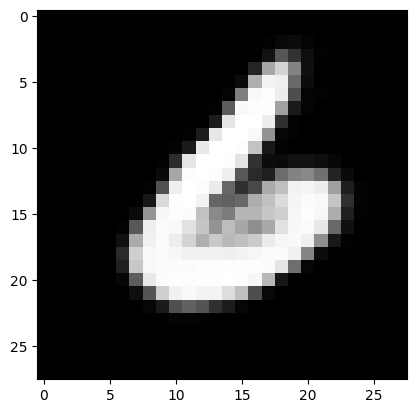

In [172]:
plt.imshow(vae_images[10], cmap='gray')

In [173]:
# Run the method to add the images
data_handler.add_gen_images(vae_images, vae_labels, 100, 'vae')

og_x, og_y = data_handler.get_original_train_data()
vae_x_train, vae_y_train = data_handler.get_train_and_vae_data()

print(f"Length of original dataset:{len(og_x)}. Length of vae augmented dataset: {len(vae_x_train)}")

VAE data has been added to the training data.
Length of original dataset:1100. Length of vae augmented dataset: 1200


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)              │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_48 (Activation)      │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_72          │ (None, 28, 28, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_49 (Activation)      │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_73          │ (None, 14, 14, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 7, 7, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_50 (Activation)      │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_74          │ (None, 7, 7, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 3, 3, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_51 (Activation)      │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_75          │ (None, 3, 3, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_77          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 21,546 (84.16 KB)

 Trainable params: 21,050 (82.23 KB)

 Non-trainable params: 496 (1.94 KB)

Epoch 1/100


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - categorical_accuracy: 0.1012 - loss: 3.1261 - precision_12: 0.1060 - recall_12: 0.0199 - val_categorical_accuracy: 0.1018 - val_loss: 2.3104 - val_precision_12: 0.0000e+00 - val_recall_12: 0.0000e+00
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.1323 - loss: 2.8423 - precision_12: 0.1085 - recall_12: 0.0214 - val_categorical_accuracy: 0.1018 - val_loss: 2.3281 - val_precision_12: 0.0000e+00 - val_recall_12: 0.0000e+00
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.1548 - loss: 2.6403 - precision_12: 0.1993 - recall_12: 0.0302 - val_categorical_accuracy: 0.1018 - val_loss: 2.3468 - val_precision_12: 0.0000e+00 - val_recall_12: 0.0000e+00
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.1789 - loss: 2.5577 - precision_12: 0.2799 - recall_12: 0.0464 - val_categorical_accuracy: 0.1018 - val_loss: 2.3738 - val_precision_12: 0.0000e+00 - val_recall_12: 0.0000e

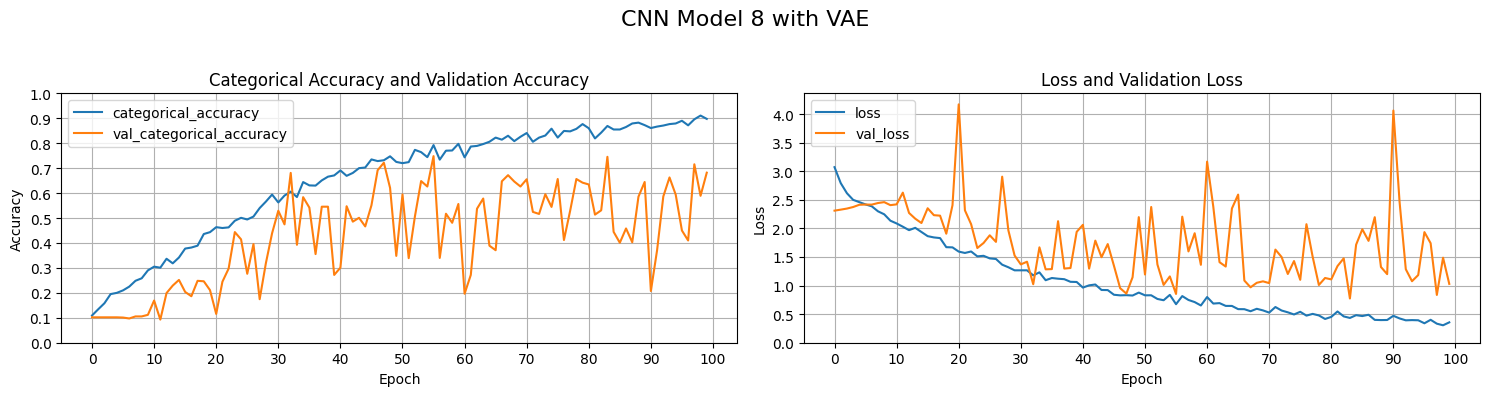

In [174]:
# Get the model
conv_2d8_vae_data = ModelConv2D8()
model8_vae_data = conv_2d8_vae_data.define_model()
model8_vae_data.summary()

# Train Model
history8_vae = model8_vae_data.fit(vae_x_train, vae_y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test))

# Save the entire model
model8_vae_data.save('saved_models/model8_vae_data.keras')

## Save the history object to a file
with open('saved_histories/history8_vae.json', 'w') as file:
    json.dump(history8_vae.history, file)

# Load the history object from the file
with open('saved_histories/history8_vae.json', 'r') as file:
    history8_vae = json.load(file)

plot(history8_vae, 'CNN Model 8 with VAE')

## Model 10 with VAE Augmented Data

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_52 (Conv2D)              │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_52 (Activation)      │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 28, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_53 (Activation)      │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_79          │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_54 (Activation)      │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_80          │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_55 (Activation)      │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_81          │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_82          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_83          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 111,690 (436.29 KB)

 Trainable params: 110,954 (433.41 KB)

 Non-trainable params: 736 (2.88 KB)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - categorical_accuracy: 0.1135 - loss: 3.0132 - precision_13: 0.1550 - recall_13: 0.0382 - val_categorical_accuracy: 0.0918 - val_loss: 2.3164 - val_precision_13: 0.0000e+00 - val_recall_13: 0.0000e+00
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - categorical_accuracy: 0.2135 - loss: 2.5491 - precision_13: 0.3250 - recall_13: 0.0764 - val_categorical_accuracy: 0.0918 - val_loss: 2.3454 - val_precision_13: 0.0000e+00 - val_recall_13: 0.0000e+00
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - categorical_accuracy: 0.2531 - loss: 2.4242 - precision_13: 0.3283 - recall_13: 0.0686 - val_categorical_accuracy: 0.0918 - val_loss: 2.4094 - val_precision_13: 0.0000e+00 - val_recall_13: 0.0000e+00
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - categorical_accuracy: 0.3058 - loss: 2.1969 - precision_13: 0.4314 - recall_13: 0.0944 - val_categorical_accuracy: 0.1127 - val_loss: 2.4577 - val_precision_13: 0.0000e+00 - val_recall

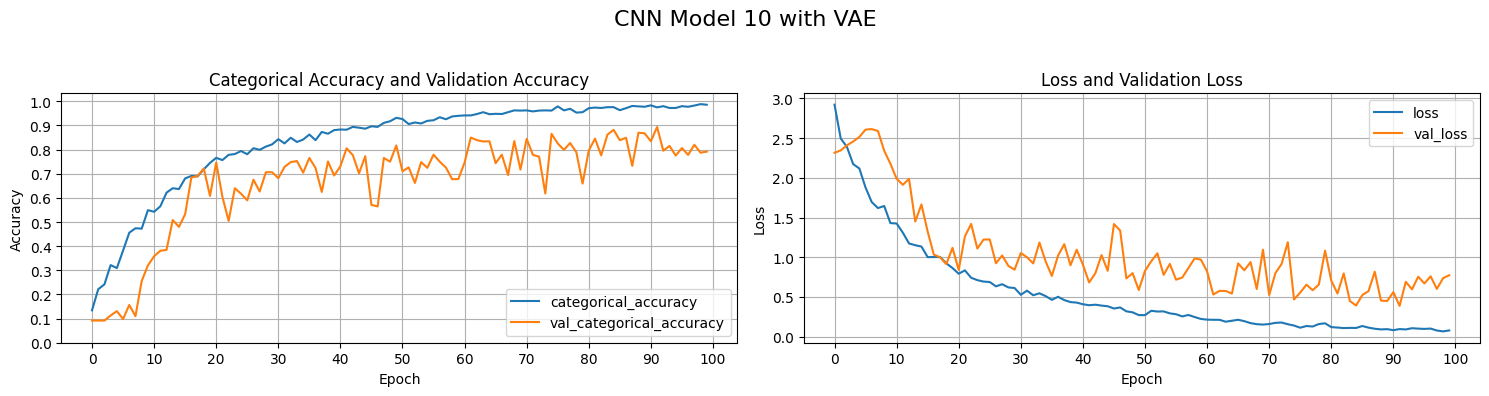

In [175]:
# Get the model
conv_2d10_vae_data = ModelConv2D10()
model10_vae_data = conv_2d10_vae_data.define_model()
model10_vae_data.summary()

# Train model
history10_vae = model10_vae_data.fit(vae_x_train, vae_y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test))

# Save the entire model
model10_vae_data.save('saved_models/model10_vae_data.keras')

#Save the history object to a file
with open('saved_histories/history10_vae.json', 'w') as file:
    json.dump(history10_vae.history, file)

# Load the history object from the file
with open('saved_histories/history10_vae.json', 'r') as file:
    history10_vae = json.load(file)

plot(history10_vae, 'CNN Model 10 with VAE')

In [177]:
import pandas as pd
# Create a table to compare the results

history_list = [
    ("model 8", 'original', history8_og),
    ("model 10", "original", history10_og),
    ("model 8", "augmented", history8_aug),
    ("model 10", "augmented", history10_aug),
    ("model 8", "dcgan", history8_dcgan),
    ("model 10", "dcgan", history10_dcgan),
    ("model 8", "vae", history8_vae),
    ("model 10", "vae", history10_vae)]

cols = ['model', 'dataset', 'best_test_accuracy', 'best_train_accuracy', 'avg_test_accuracy', 'avg_train_accuracy', 'precision', 'recall']
results_data = []


for model, dataset_type, hist_obj in history_list:
    row_data = {}
    # Set the model
    row_data['model'] = model
    row_data['dataset'] = dataset_type
    # Set the accuracy metrics
    row_data['best_train_accuracy'] = round(max(hist_obj["categorical_accuracy"]), 3)
    row_data['best_test_accuracy'] = round(max(hist_obj["val_categorical_accuracy"]), 3)
    row_data['avg_train_accuracy'] = round(sum(hist_obj["categorical_accuracy"]) / len(hist_obj["categorical_accuracy"]), 4)
    row_data['avg_test_accuracy'] = round(sum(hist_obj["val_categorical_accuracy"]) / len(hist_obj["val_categorical_accuracy"]), 4)  

    # the name for precision, recall and val change, let's find it 
    # auc_key = [key for key in hist_obj.keys() if "val_auc" in key][0]
    precision_key = [key for key in hist_obj.keys() if "val_precision" in key][0]
    recall_key = [key for key in hist_obj.keys() if "val_recall" in key][0]
    
    # row_data['auc'] = round(max(hist_obj[auc_key]), 3)
    row_data['recall'] = round(max(hist_obj[recall_key]), 3)
    row_data['precision'] = round(max(hist_obj[precision_key]), 3)
    results_data.append(row_data)


# Apply the function to the DataFrame
results_df = pd.DataFrame(results_data, columns=cols)

# Sort the DataFrame by 'best_test_accuracy' in descending order
sorted_df = results_df.sort_values(by="best_test_accuracy", ascending=False)

# Define a function to highlight the maximum value in each numerical column, skipping the first two columns
def highlight_max_numerical(s):
    if s.name in sorted_df.select_dtypes(include='number').columns:  # Check if column is numerical
        is_max = s == s.max()
        return ['background-color: blue' if v else '' for v in is_max]
    else:
        return ['']*len(s)

# Apply the function to the DataFrame
styled_df = sorted_df.style.apply(highlight_max_numerical, axis=0)

# Display the styled DataFrame
styled_df


,model,dataset,best_test_accuracy,best_train_accuracy,avg_test_accuracy,avg_train_accuracy,precision,recall
1,model 10,original,0.950000,1.000000,0.833900,0.956000,0.962000,0.945000
3,model 10,augmented,0.941000,0.966000,0.836200,0.917000,1.000000,0.929000
2,model 8,augmented,0.909000,0.957000,0.800600,0.828600,1.000000,0.898000
7,model 10,vae,0.894000,0.988000,0.669000,0.834000,0.971000,0.871000
0,model 8,original,0.888000,0.994000,0.746300,0.853500,0.908000,0.875000
5,model 10,dcgan,0.887000,0.978000,0.540700,0.795700,1.000000,0.856000
4,model 8,dcgan,0.835000,0.836000,0.526800,0.570500,0.971000,0.733000
6,model 8,vae,0.748000,0.911000,0.430000,0.655300,0.893000,0.665000


In [178]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from tensorflow.keras.models import load_model

def plot_confusion_matrices(models_info, x_test, y_test):
        # Create a grid for plotting
    fig, axes = plt.subplots(4, 2, figsize=(10, 20))  # Adjust figsize as needed
    axes = axes.flatten()  # Flatten the axes array for easy indexing
    
    for i, (model_name, model_path) in enumerate(models_info):
        # Load the model
        model = load_model(model_path)
        
        # Make predictions
        y_pred_probs = model.predict(x_test)
        y_pred_classes = np.argmax(y_pred_probs, axis=1)
        
        # Convert y_test from one-hot encoded to class labels
        y_true_classes = np.argmax(y_test, axis=1)
        
        # Compute confusion matrix
        cm = confusion_matrix(y_true_classes, y_pred_classes)
        
        # Display confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=axes[i], cmap=plt.cm.Blues, colorbar=False)  # Use the current axis
        
        # Add a title
        axes[i].set_title(model_name)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Show the plot
    plt.show()

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


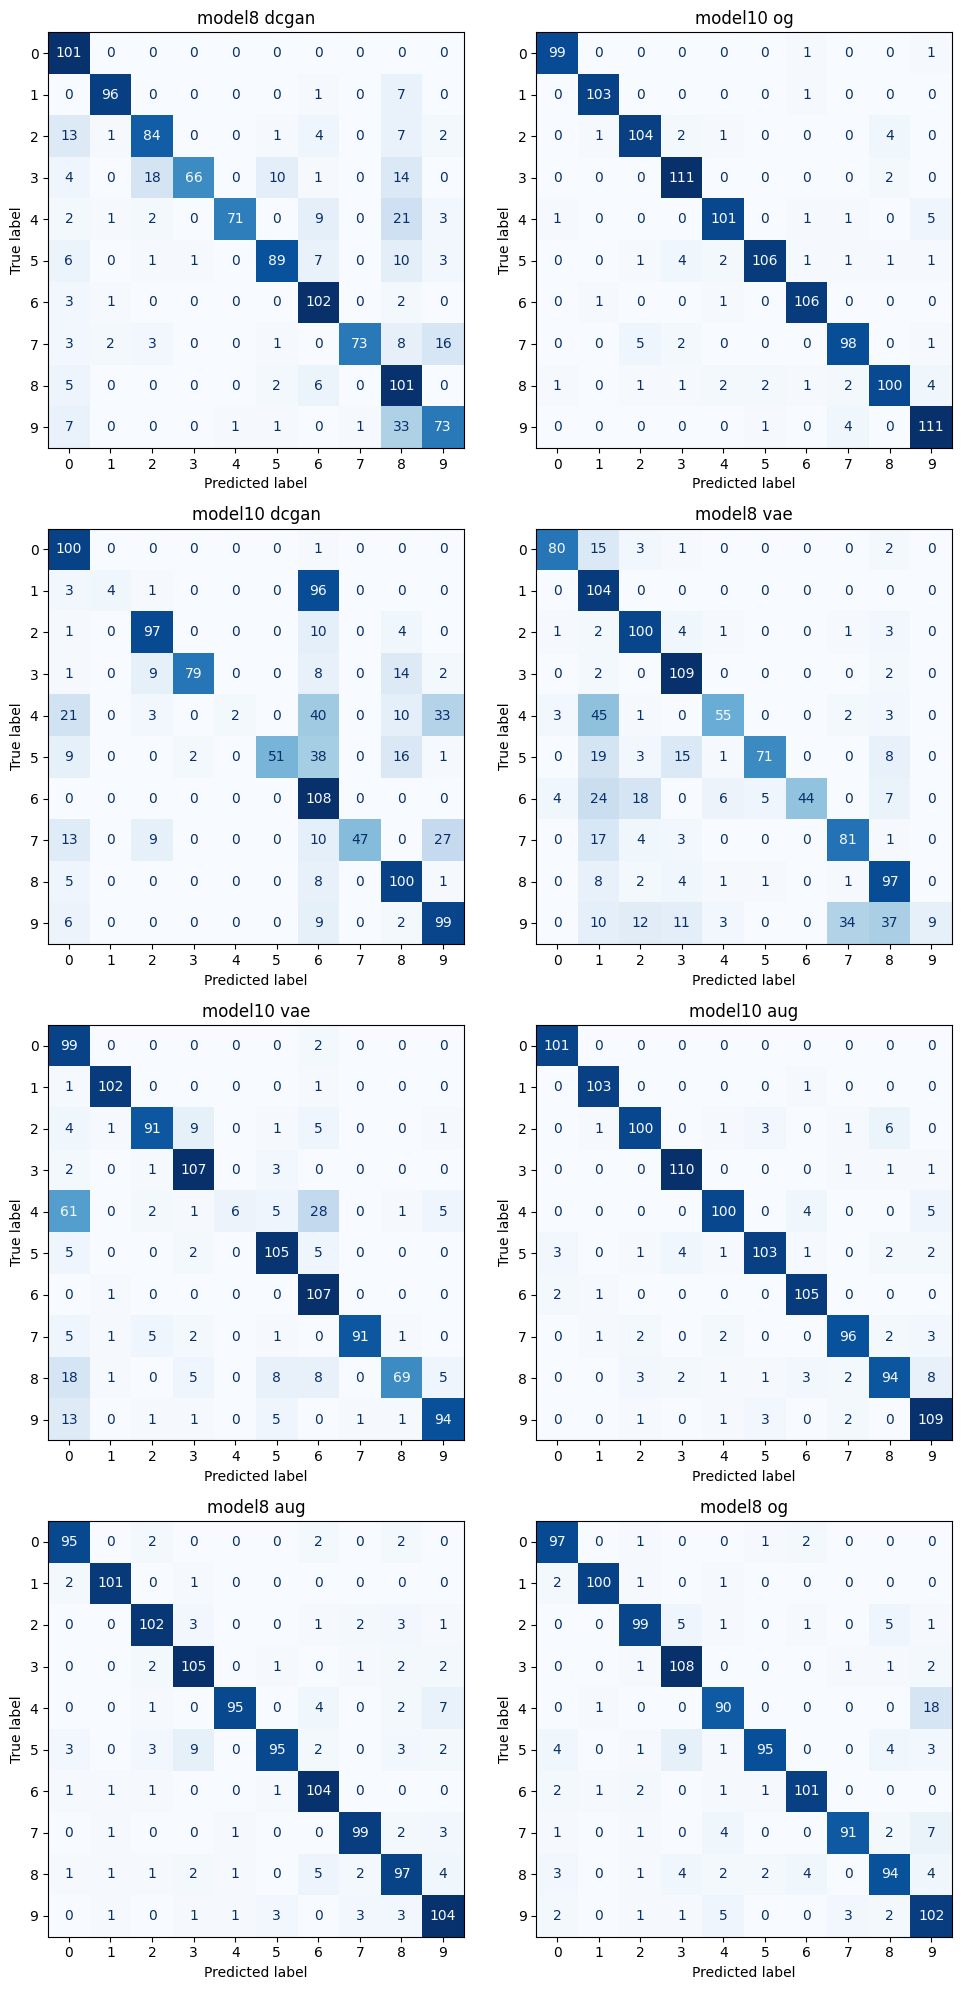

In [179]:
import os
# Create the model list

os.chdir('/Users/richardogujawa/Documents/ATU/Dissertation/dissertation_artefact/saved_models')
saved_models = os.listdir()
models_info = [(model.split('_data')[0].replace('_', ' '), model)for model in saved_models]
models_info

# Assuming x_test and y_test are already defined
plot_confusion_matrices(models_info, x_test, y_test)

{'categorical_accuracy': [0.12909090518951416, 0.16363635659217834, 0.21454545855522156, 0.2627272605895996, 0.29818183183670044, 0.36818182468414307, 0.39636364579200745, 0.459090918302536, 0.4727272689342499, 0.5190908908843994, 0.557272732257843, 0.5581818222999573, 0.6263636350631714, 0.6336363554000854, 0.6736363768577576, 0.6972727179527283, 0.7081817984580994, 0.7054545283317566, 0.7454545497894287, 0.7599999904632568, 0.7754545211791992, 0.774545431137085, 0.7881818413734436, 0.8090909123420715, 0.8127272725105286, 0.8363636136054993, 0.8409090638160706, 0.8336363434791565, 0.8600000143051147, 0.864545464515686, 0.8672727346420288, 0.8727272748947144, 0.8790909051895142, 0.8972727060317993, 0.8899999856948853, 0.9118182063102722, 0.9036363363265991, 0.910909116268158, 0.9027272462844849, 0.914545476436615, 0.9309090971946716, 0.921818196773529, 0.9281818270683289, 0.9063636660575867, 0.9336363673210144, 0.9354545474052429, 0.946363627910614, 0.9563636183738708, 0.94090908765792

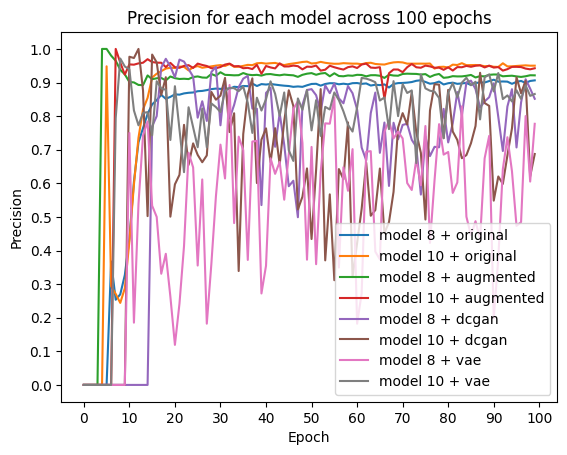

In [182]:
# Plot the precision for each model
def plot_attribute(attr):
    legend_details = []
    # Plot categorical accuracy and validation accuracy
    for model, dataset_type, hist_obj in history_list:
        print(hist_obj)
        # the attribute name isn't always straight forward, so it's need to be found first
        attr_key = [key for key in hist_obj.keys() if f"val_{attr}" in key][0]
        plt.plot(hist_obj[attr_key])
        legend_details.append(f"{model} + {dataset_type}")
    
    plt.legend(legend_details)
    plt.title(f'{attr.capitalize()} for each model across 100 epochs')
    plt.xlabel('Epoch')
    plt.ylabel(attr.capitalize())
    # Adding more ticks
    plt.xticks(np.arange(0, 110, step=10))
    plt.yticks(np.arange(0, 1.1, step=0.1))
    
    plt.show()
    # plt.grid(True)

# plot_attribute('categorical_accuracy')
# plot_attribute('recall')
plot_attribute('precision')

    